<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:white;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:left;vertical-align:top}
</style>


# 03 Extract the rind (compare to the other tissue extraction notebook)

Looking at individual fruit scans now, we can start segmenting the tissues of interest. 

- Exocarp
- Endocarp
- Rind
- Central column (spine)

Given the diversity of fruit shapes, and different scan qualities, I wasn't able to find a nice fully-automated solution.

- Instead, there I set a general process, a combination of basic image morphology operations in combination of some hyperparameters
- Manually set the hyperparameters for each fruit on a trial-and-error basis.

The order of the steps, _aka_ the order in which the tissues are extracted, had to be altered for some cases.
- Additional steps might also be required for other fruits

Usually the individual fruits from the same raw scan use the same hyperparameters.

**Take this notebook as a _suggestion_ on how to extract tissues rather than an automated code**

<table class="tg">

<tbody>
  <tr>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_spine.gif" alt = "barley" style="width:175px;"/>
        <p style="text-align:center;font-size:20px"><strong>central column</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_endocarp.gif" alt = "barley" style="width:175px;"/>
        <p style="text-align:center;font-size:20px"><strong>endocarp</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_rind.gif" alt = "Website icon" style="width:175px;"/>
        <p style="text-align:center;font-size:20px"><strong>rind</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_exocarp.gif" alt="NSF Logo" style="width:175px">
        <p style="text-align:center;font-size:20px"><strong>exocarp</strong></p>
    </td>
  </tr>
</tbody>
</table>

In [2]:
import os
import sys
import glob
from importlib import reload

from matplotlib import pyplot as plt

import scipy.ndimage as ndimage
import scipy.spatial as spatial
import numpy as np
import pandas as pd

import tifffile as tf
import citrus_utils as vitaminC

### Load the whole (individual) fruit scan

- `rname` is the root name of the files (the use of _root_ bears no direct link with the botanical sense, but more of a computational/linguistic sense)
- It is `WR18_CRC2863_12A-39-9` in this case, which corresponds to a Carrizo Citrange (see supplementary data)
- `lname` is the label of this specific replicate. 
- It is the `L03` replicate in this case
- This root and label will help us keep track of all the files related to this specific individual

In [4]:
src = '../data/comps/'
init_dst = '../data/tissue/'
img_files = sorted(glob.glob(src+'*.tif'))
img_file = img_files[1]
_ , fname = os.path.split(img_file)
bname = os.path.splitext(fname)[0]
img_files

['../data/comps/WR05_CRC3605_18B-19-5_L03.tif',
 '../data/comps/WR18_CRC2863_12A-39-9_L04.tif']

In [5]:
rname = '_'.join(bname.split('_')[:-1])
lname = bname.split('_')[-1]

dst = init_dst + rname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
dst += lname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
img = tf.imread(img_file)

### See the distribution of densities

[(inf, None, 117), (92399, 92, 71), (17158, 76, 77), (12, 177, 178), (9, 168, 170), (8, 185, 186), (7, 199, 206), (7, 179, 180), (6, 181, 182), (6, 172, 173), (6, 158, 159), (5, 192, 195), (5, 187, 188), (5, 34, 33), (4, 204, 203), (4, 183, 184), (3, 225, 222), (3, 218, 216), (3, 211, 227), (3, 201, 200), (3, 189, 191), (2, 240, 239), (2, 232, 231), (2, 228, 254), (2, 197, 198), (2, 161, 162), (1, 247, 246), (1, 244, 243), (1, 238, 237), (1, 223, 224), (1, 215, 214), (1, 213, 212), (1, 208, 210), (1, 19, 18), (1, 16, 15), (0, 175, 176)]
100


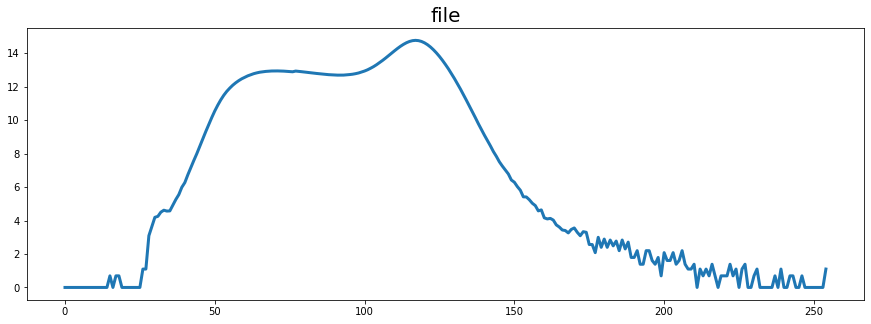

In [6]:
thr = vitaminC.get_individual_threshold(img, True)
print(thr)

In [50]:
rtholded = img.copy()
rtholded[rtholded > 105] = 0

size = 3
esize = (size, size, size)
orind = ndimage.grey_opening(rtholded, size=esize, mode='constant')
#orind = ndimage.grey_opening(orind, size=esize, mode='constant')
#orind = ndimage.grey_opening(orind, size=esize, mode='constant')

In [52]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
erind = ndimage.binary_closing(orind, structure=struc, iterations=size)
erind = ndimage.binary_closing(erind, structure=struc, iterations=size)
#erind = ndimage.binary_dilation(erind, structure=struc, iterations=size+2)

In [53]:
trind = vitaminC.get_largest_element(erind)

484 components
[16869478     9284     7985     3695     3438     3434     3372     3331
     2965     2911     2804     2682     2433     2399     1970     1952
     1824     1750     1356     1248]


In [54]:
rind = img*erind

2 2


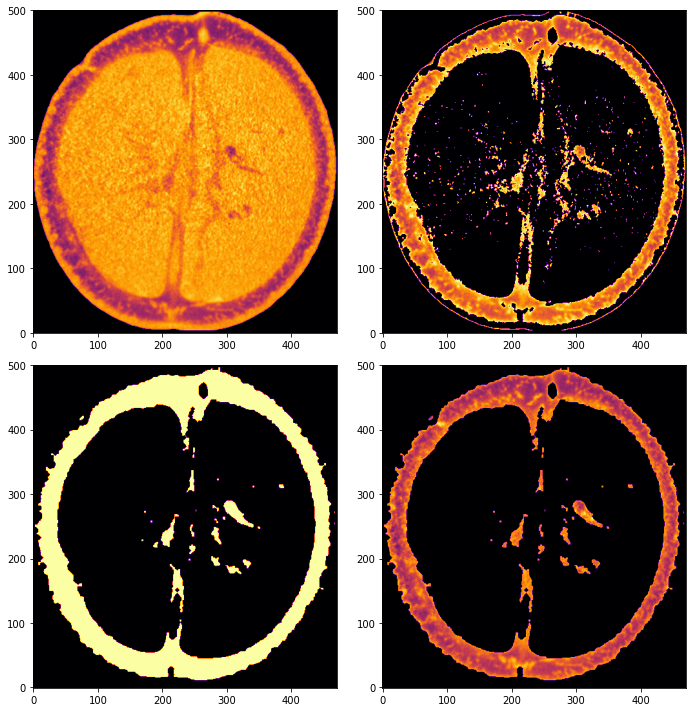

In [55]:
k = 250
ss = np.s_[:, k, :]
vitaminC.plot4x4panel([img, rtholded, erind , rind], ss, bname=bname)

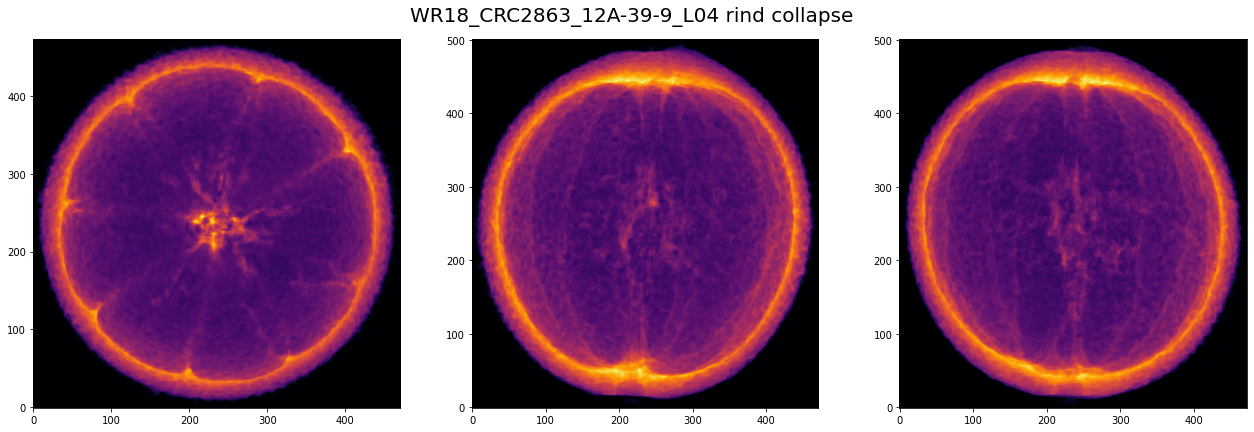

In [56]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(rind)
vitaminC.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

In [57]:
filename = dst + bname + '_rind.tif'
tf.imwrite(filename, rind, photometric='minisblack',compress=3)

# Endocarp

In [67]:
rind = tf.imread(dst + bname + '_rind.tif')
cendo = rind.copy()
cendo[cendo > 0] = 1

eimg = img.copy()
eimg = ndimage.grey_erosion(img, size=(15,15,15), mode='constant')

In [68]:
#eimg = ndimage.grey_erosion(eimg, size=(15,15,15), mode='constant')
eimg = ndimage.grey_erosion(eimg, size=(9,9,9), mode='constant')
#eimg = ndimage.grey_erosion(eimg, size=(5,5,5), mode='constant')
#eimg = ndimage.grey_erosion(eimg, size=(15,15,15), mode='constant')

In [73]:
dendo = eimg.copy()
dendo[dendo > 0] = 1

endocarp = img*dendo*(1-cendo)

In [74]:
dendo = endocarp.copy()
dendo[dendo > 0] = 1

#dendo = ndimage.grey_closing(endocarp, size=(15,15,15), mode='constant')
#dendo = ndimage.grey_closing(dendo, size=(9,9,9), mode='constant')
#dendo = ndimage.grey_opening(dendo, size=(9,9,9), mode='constant')

tendo = vitaminC.get_largest_element(dendo)

53 components
[34580518      239      206      117       98       85       81       67
       64       56       55       48       45       44       42       40
       39       37       32       25]


In [83]:
dendo = ndimage.grey_closing(tendo, size=(9,9,9), mode='constant')
dendo = ndimage.grey_closing(dendo, size=(15,15,15), mode='constant')
#dendo = ndimage.grey_dilation(dendo, size=(9,9,9), mode='constant')

In [84]:
endocarp = img*dendo

2 2


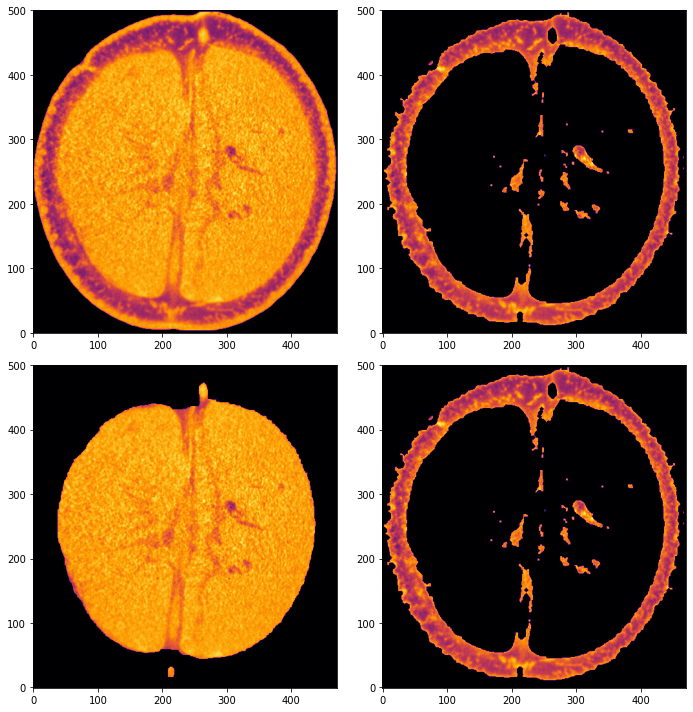

In [86]:
k = 250
ss = np.s_[:, k, :]
vitaminC.plot4x4panel([img, rind,endocarp, rind], ss, bname=bname)

In [87]:
filename = dst + bname + '_endocarp.tif'
tf.imwrite(filename, endocarp, photometric='minisblack',compress=3)

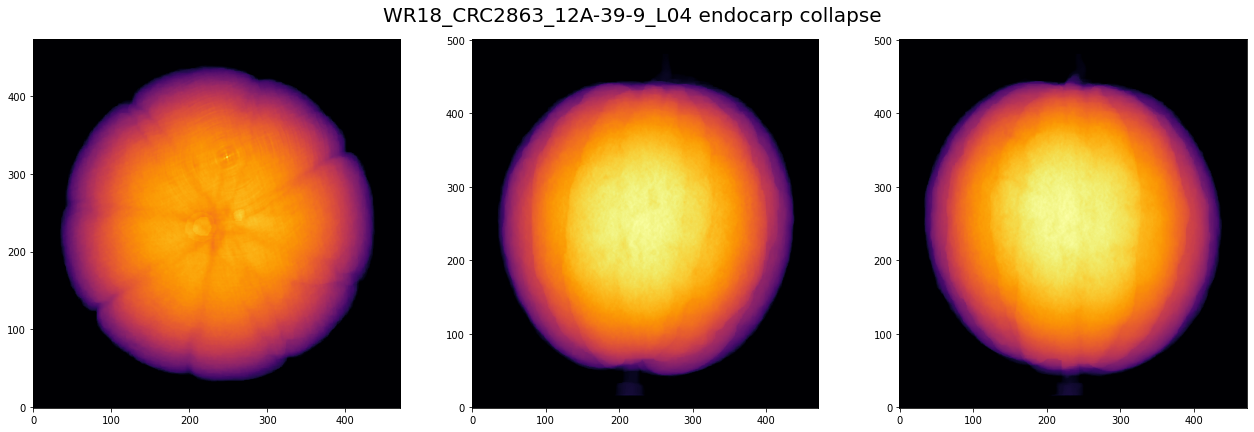

In [88]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(endocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'endocarp', display=display, writefig=writefig, dst=diag_dst)

# Exocarp

In [89]:
dendo = endocarp.copy()
dendo[dendo > 0] = 1

drind = rind.copy()
drind[drind > 0] = 1

In [90]:
comp = drind + dendo - drind*dendo
comp = comp.astype(np.uint8)

In [91]:
rcomp = ndimage.binary_fill_holes(comp)

In [92]:
iters = 5
struc = ndimage.generate_binary_structure(img.ndim, img.ndim-1)

ertholded = ndimage.binary_erosion(rcomp, iterations=iters, structure=struc)

In [94]:
tendo = img*(1-ertholded)
tendo[tendo < thr] = 0
tendo[tendo > 0] = 1
tendo = ndimage.binary_closing(tendo, iterations=5, structure=struc)

In [95]:
exocarp = img*tendo

2 2


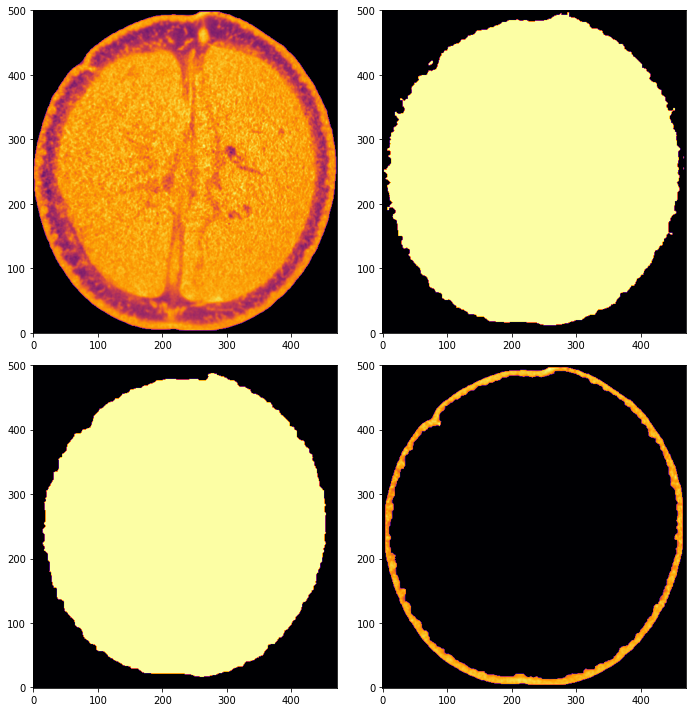

In [98]:
k = 250
ss = np.s_[:, k, :]
vitaminC.plot4x4panel([img, rcomp, ertholded, exocarp], ss, bname=bname)

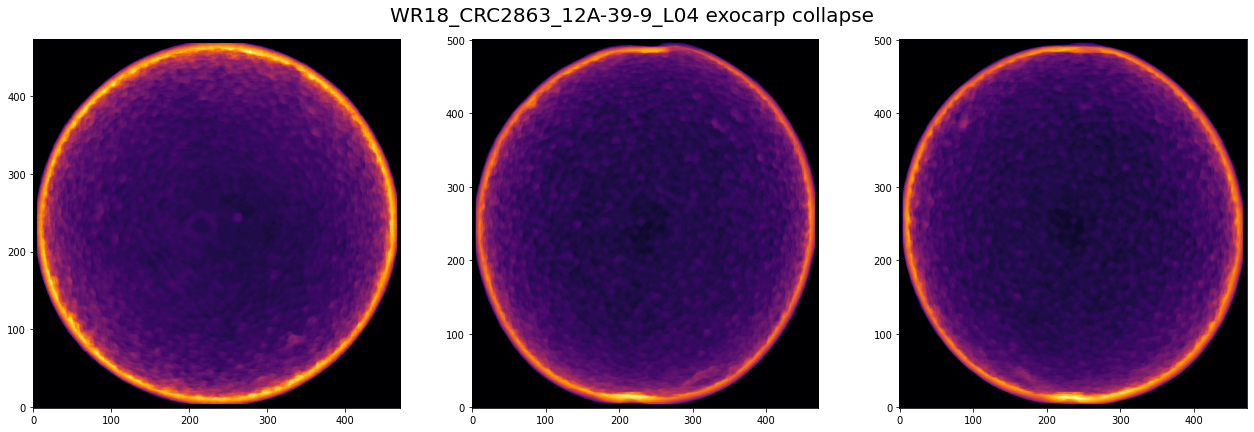

In [100]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(exocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'exocarp', display=display, writefig=writefig, dst=diag_dst)

In [99]:
filename = dst + bname + '_exocarp.tif'
tf.imwrite(filename, exocarp, photometric='minisblack',compress=3)

# Spine

In [101]:
endo = vitaminC.fill_component(dendo)

Closed X
Closed Y
Closed Z


In [102]:
size = 11
esize = (size, size, size)

eendo = ndimage.grey_erosion(endo, size=esize, mode='constant')

tspine = rind*eendo
tspine = vitaminC.get_largest_element(tspine)

402 components
[339690   9284   7985   3695   3438   3434   3372   3331   2965   2911
   2682   2433   2399   1970   1952   1824   1750   1356   1248   1147]


In [103]:
size = 5
eesize = (size, size, size)
#orind = ndimage.grey_opening(tspine, size=(8,8,8), mode='constant')
#eesize = (3*size, 1, 1)
orind = ndimage.grey_dilation(tspine, size=eesize, mode='constant')

In [104]:
tspine = vitaminC.get_largest_element(orind)

1 components
[841081]


In [105]:
spine = rind*orind
mesocarp = rind*(1-orind)

In [106]:
tendo = vitaminC.get_largest_element(mesocarp)

436 components
[16519250     9284     7985     3695     3438     3434     3372     3331
     2965     2911     2804     2682     2433     2399     1970     1952
     1824     1750     1356     1248]


In [107]:
mesocarp *= tendo

2 2


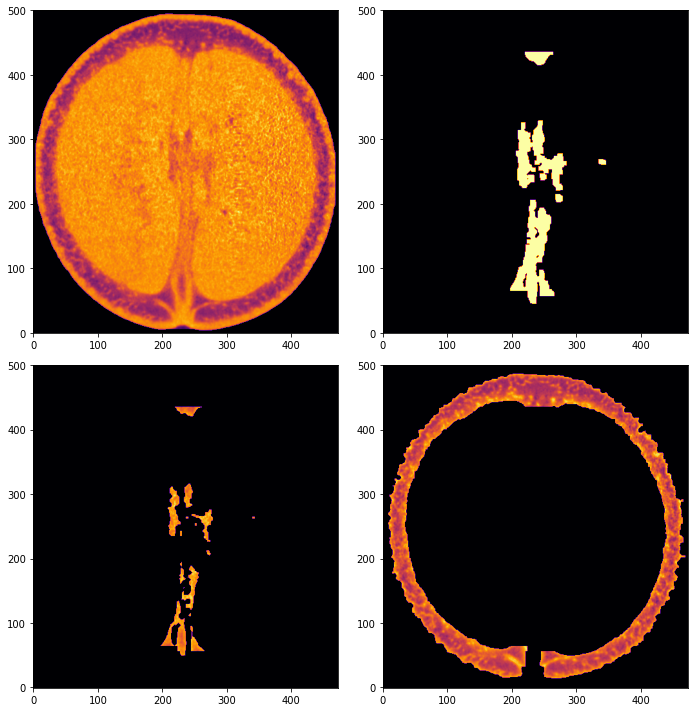

In [111]:
k = 220
ss = np.s_[:, :, k]
vitaminC.plot4x4panel([img, orind, spine, mesocarp], ss, bname=bname)

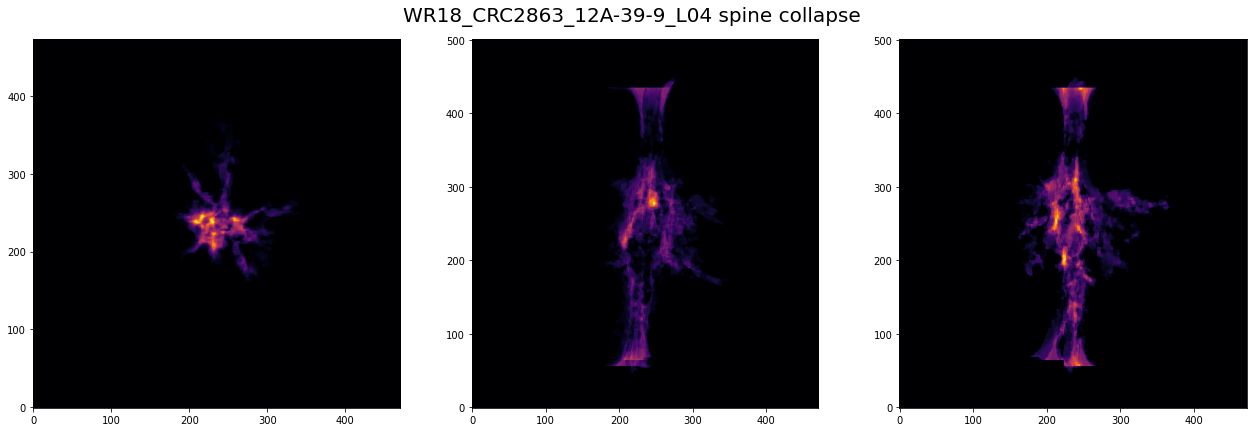

In [112]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(spine)
vitaminC.plot_collapse_dimensions(snaps, bname, 'spine', display=display, writefig=writefig, dst=diag_dst)

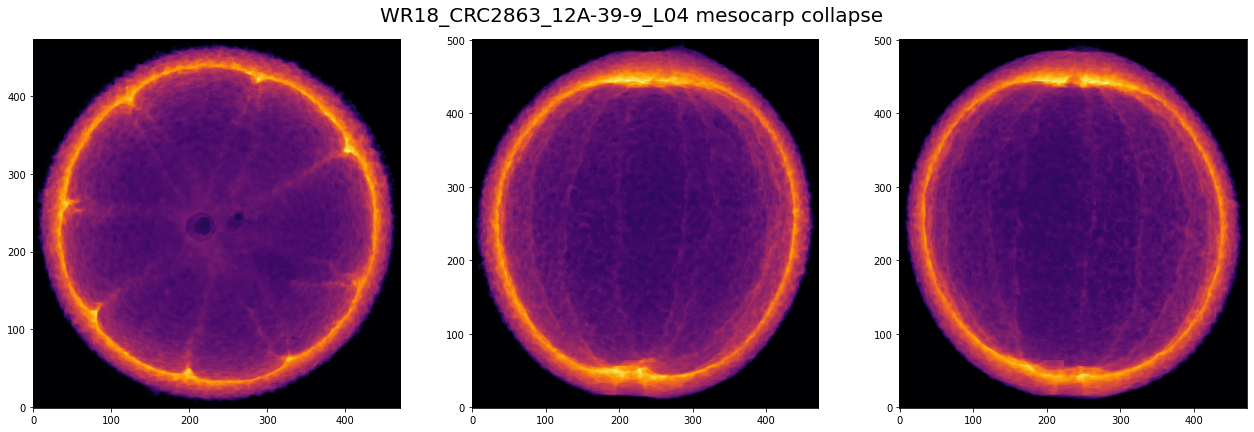

In [113]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(mesocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'mesocarp', display=display, writefig=writefig, dst=diag_dst)

In [114]:
filename = dst + bname + '_spine.tif'
tf.imwrite(filename, spine, photometric='minisblack',compress=3)

# Endocarp

In [83]:
bin_spine = spine.copy()
bin_spine[bin_spine > 0] = 1

In [91]:
size = 5
struc = ndimage.generate_binary_structure(img.ndim, 2)

#rtholded = ndimage.binary_dilation(endo, structure=struc, iterations=size)
rtholded = ndimage.binary_opening(endo, structure=struc, iterations=2*size)
rtholded = ndimage.binary_closing(rtholded, structure=struc, iterations=2*size)

In [92]:
endocarp = rtholded*img*(1-bin_spine)
endocarp[endocarp < 170] = 0

In [93]:
tendo = vitaminC.get_largest_element(endocarp)

8861 components
[67189176     1667     1083     1080     1046     1009      848      716
      604      554      502      483      408      395      393      390
      317      292      279      279]


In [94]:
rtholded = ndimage.binary_closing(tendo, structure=struc, iterations=5)

In [98]:
rtholded = ndimage.binary_closing(rtholded, structure=struc, iterations=2)
rtholded = ndimage.binary_closing(rtholded, structure=struc, iterations=2)

In [99]:
endocarp = rtholded*img

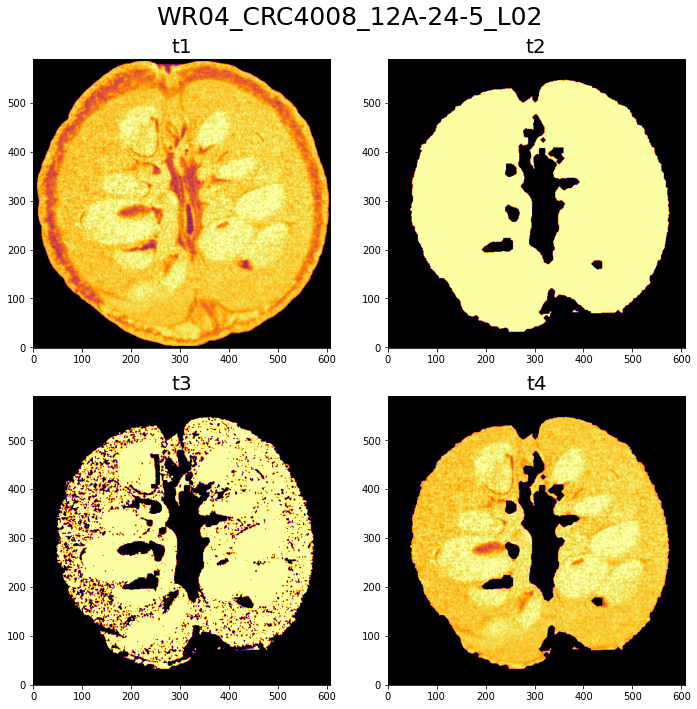

In [100]:
k = 270
ss = np.s_[:,k, :]
vitaminC.plot4x4panel(img, rtholded, tendo, endocarp, ss, bname=bname)

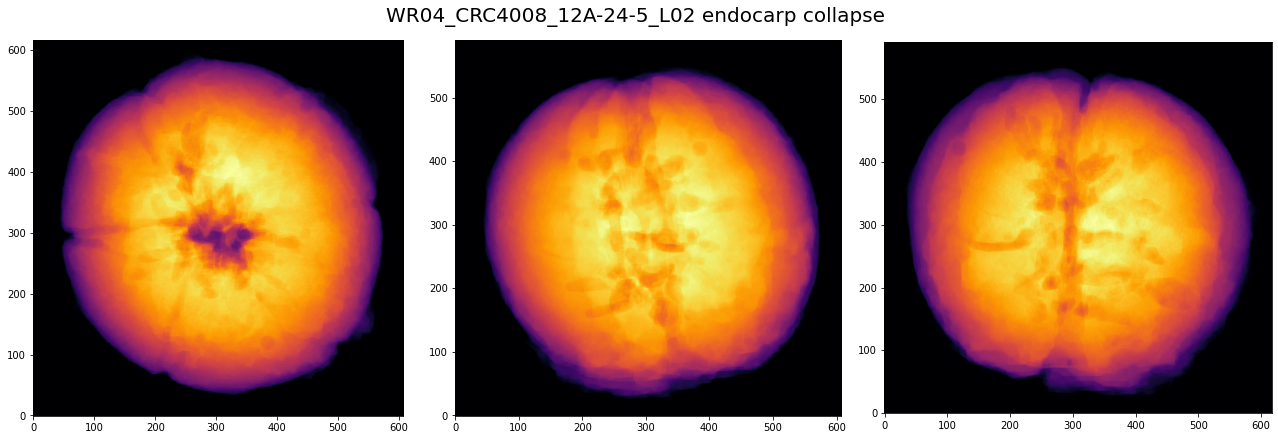

In [101]:
writefig = False
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(endocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'endocarp', display=display, writefig=writefig, dst=diag_dst)